# Price Sensitivity Analysis of NYC High Volume FHV Trips (Uber / Lyft)

**Course:** NYU – Data Science (Final Project)  
**Focus of this notebook:** Step 3 – Price Sensitivity (Q3-1 ~ Q3-4)  
**Author:** Jeremy Hsu

---

## Goal of Step 3

**Big question for Step 3:**

> For each area and time, how sensitive is demand to price?  
> i.e., *“If we increase price by X%, how much does demand drop (in %)?”*

This step connects Step 2 (price vs demand patterns) and Step 4 (revenue impact).
We will:

1. Define a **relative price** for each zone–hour (price compared to the “normal” price there).
2. Classify price into **Low / Medium / High** bands.
3. Measure **how trip counts change when price moves from Medium → High or Medium → Low**.
4. Turn that into a **price sensitivity (elasticity) measure** by zone, hour, demand level, and journey type.

At the end, we will produce clean tables that Step 4 (revenue analysis) can directly reuse.


In [2]:
# 0. Imports & basic setup

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (8, 5)

# Find project root by looking for src/data_loader.py
current = Path.cwd()
project_root = current
while project_root != project_root.parent:
    if (project_root / "src" / "data_loader.py").exists():
        break
    project_root = project_root.parent

sys.path.insert(0, str(project_root))

from src.data_loader import TLCDataLoader


## 0.1 Data Loading

We use the official TLC **High Volume FHV Trip Records** (Uber, Lyft, etc., 2024) and a small custom loader:

- We keep only a few core columns that we need for Step 3:
  - `PULocationID` – pickup zone
  - `pickup_datetime` – pickup time
  - `trip_miles` – trip distance
  - `base_passenger_fare` – base passenger fare (before tips, tolls, etc.)

For development we use a 10% sample; for final run we can set `sample_ratio=1.0`.


In [3]:
# 0.2 Load raw data using custom TLCDataLoader

loader = TLCDataLoader(str(project_root / "data" / "raw"))

columns_to_use = [
    "PULocationID",
    "pickup_datetime",
    "trip_miles",
    "base_passenger_fare",
]

all_months = [f"2024-{i:02d}" for i in range(1, 12 + 1)]

df_raw = loader.load(
    features=columns_to_use,
    months=all_months,
    sample_ratio=1,  # 0.1 for testing; use 1.0 for final run
)

print(f"Loaded {len(df_raw):,} trips")
df_raw.head()


TLCDataLoader initialized with 12 monthly files.
Selected 12 files: ['fhvhv_tripdata_2024-01.parquet', 'fhvhv_tripdata_2024-02.parquet', 'fhvhv_tripdata_2024-03.parquet', 'fhvhv_tripdata_2024-04.parquet', 'fhvhv_tripdata_2024-05.parquet', 'fhvhv_tripdata_2024-06.parquet', 'fhvhv_tripdata_2024-07.parquet', 'fhvhv_tripdata_2024-08.parquet', 'fhvhv_tripdata_2024-09.parquet', 'fhvhv_tripdata_2024-10.parquet', 'fhvhv_tripdata_2024-11.parquet', 'fhvhv_tripdata_2024-12.parquet']
Loading columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Ready columns: ['PULocationID', 'pickup_datetime', 'trip_miles', 'base_passenger_fare']
Loaded 239,470,448 trips


PULocationID,pickup_datetime,trip_miles,base_passenger_fare
i32,datetime[μs],f64,f64
161,2024-01-01 00:28:08,2.83,45.61
137,2024-01-01 00:12:53,1.57,10.05
79,2024-01-01 00:23:05,1.98,18.07
234,2024-01-01 00:41:04,1.99,17.17
148,2024-01-01 00:57:21,2.65,38.67


## 1. Data Cleaning & Feature Engineering

We clean the data with a few simple, transparent rules:

1. Parse `pickup_datetime` into a proper datetime.
2. Drop rows where `trip_miles` or `base_passenger_fare` are non-positive or null.
3. Derive:
   - `pickup_hour`: hour of day (0–23)
   - `pickup_dayofweek`: day of week (0=Monday, …, 6=Sunday)
   - `price_per_mile`: `base_passenger_fare / trip_miles`

These are all **basic, interpretable transformations** that we will reuse in all Q3 sub-questions.


In [4]:
# 1.1 Type conversion and basic cleaning
# NOTE: TLCDataLoader already handles datetime normalization, so pickup_datetime is already Datetime type

df_clean = (
    df_raw
    .with_columns([
        # Ensure numeric columns are Float64 (they might already be, but casting is safe)
        pl.col("trip_miles").cast(pl.Float64),
        pl.col("base_passenger_fare").cast(pl.Float64),
    ])
    .drop_nulls(["pickup_datetime", "trip_miles", "base_passenger_fare"])
    .filter(
        (pl.col("trip_miles") > 0) &
        (pl.col("base_passenger_fare") > 0)
    )
)

print("After cleaning:", df_clean.shape)
print(df_clean.dtypes)
df_clean.head()


After cleaning: (239361566, 4)
[Int32, Datetime(time_unit='us', time_zone=None), Float64, Float64]


PULocationID,pickup_datetime,trip_miles,base_passenger_fare
i32,datetime[μs],f64,f64
161,2024-01-01 00:28:08,2.83,45.61
137,2024-01-01 00:12:53,1.57,10.05
79,2024-01-01 00:23:05,1.98,18.07
234,2024-01-01 00:41:04,1.99,17.17
148,2024-01-01 00:57:21,2.65,38.67


In [5]:
# 1.2 Add time and price features

df_clean = (
    df_clean
    .with_columns([
        pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
        pl.col("pickup_datetime").dt.weekday().alias("pickup_dayofweek"),
        (pl.col("base_passenger_fare") / pl.col("trip_miles")).alias("price_per_mile"),
    ])
)

df_clean.select([
    "PULocationID", "pickup_datetime",
    "pickup_hour", "pickup_dayofweek",
    "trip_miles", "base_passenger_fare", "price_per_mile"
]).head()


PULocationID,pickup_datetime,pickup_hour,pickup_dayofweek,trip_miles,base_passenger_fare,price_per_mile
i32,datetime[μs],i8,i8,f64,f64,f64
161,2024-01-01 00:28:08,0,1,2.83,45.61,16.116608
137,2024-01-01 00:12:53,0,1,1.57,10.05,6.401274
79,2024-01-01 00:23:05,0,1,1.98,18.07,9.126263
234,2024-01-01 00:41:04,0,1,1.99,17.17,8.628141
148,2024-01-01 00:57:21,0,1,2.65,38.67,14.592453


**Why `price_per_mile`?**

- Raw fare is not directly comparable across trips of very different distances.
- `price_per_mile` makes “expensive vs cheap” more comparable across trip lengths.
- Later we will compare **relative price** to the typical price in the same zone & time.


## 2. Constructing a Zone–Hour–Weekday Panel

To analyze price sensitivity, we aggregate the trip-level data into a **panel**:

- Key: `(PULocationID, pickup_hour, pickup_dayofweek)`
- For each cell, we compute:
  - `avg_price`: average `price_per_mile`
  - `avg_miles`: average `trip_miles`
  - `trip_count`: number of trips (our demand proxy)

This panel will be the backbone for all Q3 questions.


In [6]:
panel = (
    df_clean
    .group_by(["PULocationID", "pickup_hour", "pickup_dayofweek"])
    .agg([
        pl.col("price_per_mile").mean().alias("avg_price"),
        pl.col("trip_miles").mean().alias("avg_miles"),
        pl.col("price_per_mile").count().alias("trip_count"),
    ])
)

print("Panel shape:", panel.shape)
panel.head()


Panel shape: (43535, 6)


PULocationID,pickup_hour,pickup_dayofweek,avg_price,avg_miles,trip_count
i32,i8,i8,f64,f64,u32
162,20,7,8.145026,4.212087,10458
32,23,1,5.268269,4.033876,2932
57,17,2,6.15466,4.482004,225
73,3,5,5.142403,5.65152,381
196,1,2,5.45727,4.732547,680


## 3. Relative Price & Price Categories

Key idea: **“High price” should mean “more expensive than usual in that zone and hour”.**

1. For each `(PULocationID, pickup_hour)`:
   - Compute the **median** price-per-mile across all days.  
     This is our **baseline (normal) price** for that zone–hour.
2. For each panel row:
   - `relative_price = avg_price / median_price_zone_hour`
3. Define price categories:
   - `Low`    if `relative_price < 0.90`  → >10% cheaper than normal
   - `Medium` if `0.90 ≤ relative_price ≤ 1.10`  → normal band
   - `High`   if `relative_price > 1.10`  → >10% more expensive

This definition is **local** to each zone–hour, which avoids bias from expensive vs cheap neighborhoods.


In [7]:
# 3.1 Compute median price per zone-hour (across all days)

median_price = (
    panel
    .group_by(["PULocationID", "pickup_hour"])
    .agg(
        pl.col("avg_price").median().alias("median_price_zone_hour")
    )
)

median_price.head()


PULocationID,pickup_hour,median_price_zone_hour
i32,i8,f64
134,17,6.49978
76,20,6.412736
35,16,7.822342
58,6,5.453978
180,22,5.899743


In [8]:
# 3.2 Join median price back and compute relative price

panel_rel = (
    panel
    .join(median_price, on=["PULocationID", "pickup_hour"], how="left")
    .with_columns(
        (pl.col("avg_price") / pl.col("median_price_zone_hour"))
        .alias("relative_price")
    )
)

panel_rel.select([
    "PULocationID", "pickup_hour", "pickup_dayofweek",
    "avg_price", "median_price_zone_hour", "relative_price"
]).head()


PULocationID,pickup_hour,pickup_dayofweek,avg_price,median_price_zone_hour,relative_price
i32,i8,i8,f64,f64,f64
162,20,7,8.145026,9.635767,0.845291
32,23,1,5.268269,5.392565,0.976951
57,17,2,6.15466,6.610059,0.931105
73,3,5,5.142403,5.432196,0.946653
196,1,2,5.45727,5.502719,0.991741


In [9]:
# 3.3 Define price_category based on relative_price

panel_rel = panel_rel.with_columns([
    pl.when(pl.col("relative_price") < 0.90)
        .then(pl.lit("Low"))
    .when(pl.col("relative_price") > 1.10)
        .then(pl.lit("High"))
    .otherwise(pl.lit("Medium"))
    .alias("price_category")
])

panel_rel["price_category"].value_counts()


price_category,count
str,u32
"""High""",2607
"""Medium""",37260
"""Low""",3668


# Q3-1 – Global Sanity Check: Does Higher Price Reduce Demand?

**Question:**  
> Across the whole city and all times, when price is higher than normal,  
> do we actually see fewer trips?

**Why this matters:**  
If there is no clear “price → demand” signal, then any “sensitivity” measure would be meaningless.

We test this by:

1. Using our `price_category` (Low / Medium / High).
2. Aggregating `trip_count` by price_category.
3. Comparing average demand under each price band.


In [10]:
# Q3-1: Average trip_count by price category

q31_summary = (
    panel_rel
    .group_by("price_category")
    .agg([
        pl.col("trip_count").mean().alias("avg_trip_count"),
        pl.col("trip_count").std().alias("std_trip_count"),
    ])
    .sort("price_category")
)

q31_summary


price_category,avg_trip_count,std_trip_count
str,f64,f64
"""High""",6979.574223,9147.171136
"""Low""",5746.907034,5631.750541
"""Medium""",5369.998953,5658.316919


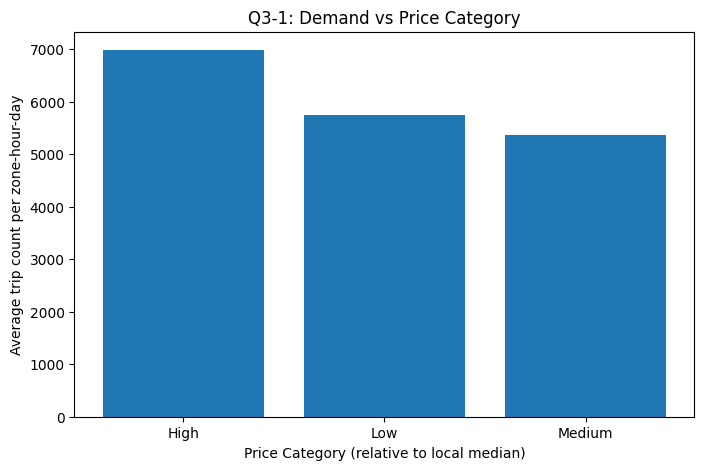

In [11]:
# Simple bar plot: avg_trip_count by price_category

fig, ax = plt.subplots()
ax.bar(
    q31_summary["price_category"].to_list(),
    q31_summary["avg_trip_count"].to_list()
)
ax.set_xlabel("Price Category (relative to local median)")
ax.set_ylabel("Average trip count per zone-hour-day")
ax.set_title("Q3-1: Demand vs Price Category")
plt.show()


## ✅ Q3-1 · Demand vs Price Category

### **Method**
- Convert price to **relative price** (vs. typical price in the same zone & hour)
- Categorize into:
  - **Low**
  - **Medium**
  - **High**
- Compare **average trip count** across categories

---

### **Result (Full-Year Data)**

| Price Category | Avg Trip Count |
|---------------|----------------|
| **High**      | **6,980** |
| **Low**       | **5,747** |
| **Medium**    | **5,370** |

📊 **High > Low > Medium**

---

### **Key Insight**
- High-price periods show the **highest demand**.
- This reflects **surge pricing during high-demand situations**, not low sensitivity.

---

### **Takeaway**
✅ Citywide averages **do NOT measure true price sensitivity**.  
➡️ We must analyze **by zone & hour** (Q3-2) to understand real behavior.


# Q3-2 – Zone-Level Price Sensitivity (Elasticity)

**Question:**  
> For each (zone, hour), how sensitive is demand to price changes?

We want a number that summarizes:

> “When price increases by 10%, demand changes by about X%”

This is essentially **price elasticity of demand**:

\[
\text{Elasticity} \approx \frac{\%\Delta Q}{\%\Delta P}
\]

### How we approximate elasticity

For each `(PULocationID, pickup_hour)`:

1. Use the **Medium price** as baseline.
2. Compare **Medium vs High** price cells:
   - ΔP% = (price_high − price_medium) / price_medium  
   - ΔQ% = (count_high − count_medium) / count_medium  
   - `elasticity_high = ΔQ% / ΔP%`
3. Similarly for **Medium vs Low**:
   - `elasticity_low = ΔQ% / ΔP%`

**Sign convention:**

- If **price increases** (ΔP% > 0) and **demand falls** (ΔQ% < 0) → elasticity is **negative**.
- The more negative the value, the **more price-sensitive** the demand.
- Values close to 0 → **price-insensitive** (demand hardly moves when price changes).


In [12]:
#  Q3-2.1 Aggregate by (zone, hour, price_category)

zone_hour_price = (
    panel_rel
    .group_by(["PULocationID", "pickup_hour", "price_category"])
    .agg([
        pl.col("relative_price").mean().alias("avg_relative_price"),
        pl.col("trip_count").mean().alias("avg_trip_count"),
    ])
)

zone_hour_price.head()


PULocationID,pickup_hour,price_category,avg_relative_price,avg_trip_count
i32,i8,str,f64,f64
187,11,"""Medium""",0.999212,1136.666667
23,3,"""High""",1.22547,596.666667
192,10,"""Medium""",1.021859,2347.0
197,19,"""Medium""",1.004579,6896.142857
79,19,"""High""",1.101643,40781.0


In [13]:
# Q3-2.2 Pivot to wide format so we have Low / Medium / High columns

zh_wide = (
    zone_hour_price
    .pivot(
        values=["avg_relative_price", "avg_trip_count"],
        index=["PULocationID", "pickup_hour"],
        columns="price_category",
    )
    .rename({
        "avg_relative_price_Medium": "price_medium",
        "avg_relative_price_Low": "price_low",
        "avg_relative_price_High": "price_high",
        "avg_trip_count_Medium": "count_medium",
        "avg_trip_count_Low": "count_low",
        "avg_trip_count_High": "count_high",
    })
)

zh_wide.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/661168007.py:5: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


PULocationID,pickup_hour,price_medium,price_high,price_low,count_medium,count_high,count_low
i32,i8,f64,f64,f64,f64,f64,f64
187,11,0.999212,1.120241,null,1136.666667,1324.0,null
23,3,0.966594,1.22547,null,512.5,596.666667,null
192,10,1.021859,null,0.881269,2347.0,null,2059.0
197,19,1.004579,null,null,6896.142857,null,null
79,19,0.991394,1.101643,0.855708,26744.0,40781.0,20754.0


In [14]:
# Q3-2.3 Function to compute elasticity for High/Low vs Medium

def compute_zone_hour_elasticity(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .with_columns([
            # % change in price (High vs Medium)
            ((pl.col("price_high") - pl.col("price_medium")) / pl.col("price_medium"))
                .alias("dP_high"),
            # % change in demand (High vs Medium)
            ((pl.col("count_high") - pl.col("count_medium")) / pl.col("count_medium"))
                .alias("dQ_high"),

            # % change in price (Low vs Medium)
            ((pl.col("price_low") - pl.col("price_medium")) / pl.col("price_medium"))
                .alias("dP_low"),
            # % change in demand (Low vs Medium)
            ((pl.col("count_low") - pl.col("count_medium")) / pl.col("count_medium"))
                .alias("dQ_low"),
        ])
        .with_columns([
            (pl.col("dQ_high") / pl.col("dP_high")).alias("elasticity_high"),
            (pl.col("dQ_low") / pl.col("dP_low")).alias("elasticity_low"),
        ])
        .select([
            "PULocationID", "pickup_hour",
            "elasticity_high", "elasticity_low",
        ])
        .drop_nulls(["elasticity_high", "elasticity_low"])
    )

elasticity_zone_hour = compute_zone_hour_elasticity(zh_wide)

print("Valid (zone, hour) combinations:", elasticity_zone_hour.shape[0])
elasticity_zone_hour.head()


Valid (zone, hour) combinations: 772


PULocationID,pickup_hour,elasticity_high,elasticity_low
i32,i8,f64,f64
79,19,4.719785,1.636486
125,17,2.238045,1.664203
162,10,0.307951,-0.052344
43,2,-1.787134,4.397017
230,10,0.030983,-0.932063


In [15]:
# Q3-2.4 Aggregate elasticity to zone-level (average across hours)

elasticity_zone = (
    elasticity_zone_hour
    .group_by("PULocationID")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_low").mean().alias("avg_elasticity_low"),
        pl.count().alias("n_observations"),
    ])
)

elasticity_zone.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/4195417532.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
8,0.360515,-3.501356,11
182,0.137149,2.008085,1
138,-0.72662,2.294707,6
59,0.953778,0.500378,7
194,-0.289491,-0.442273,6


In [16]:
# Q3-2.5 Identify price-insensitive and price-sensitive zones

price_insensitive_zones = elasticity_zone.filter(
    pl.col("avg_elasticity_high") > -0.2   # very small drop in demand when price increases
).sort("avg_elasticity_high", descending=True)

price_sensitive_zones = elasticity_zone.filter(
    pl.col("avg_elasticity_high") < -1.0   # >10% drop in demand when price ↑10%
).sort("avg_elasticity_high")

print("Top 10 price-insensitive zones (good for price increases):")
price_insensitive_zones.head(10)


Top 10 price-insensitive zones (good for price increases):


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
34,15.099928,2.375002,5
37,9.4213,2.312326,1
112,7.105774,1.642545,1
158,7.020921,2.610987,10
148,6.478924,2.256013,11
249,6.038205,2.413962,10
198,5.992557,3.301513,1
79,5.759567,2.25489,8
201,5.756558,2.793306,7


In [17]:
print("Top 10 price-sensitive zones (avoid price increases):")
price_sensitive_zones.head(10)


Top 10 price-sensitive zones (avoid price increases):


PULocationID,avg_elasticity_high,avg_elasticity_low,n_observations
i32,f64,f64,u32
157,-3.13957,5.592766,3
20,-2.895491,3.25366,2
150,-1.839193,4.64501,2
203,-1.737018,-6.822776,1
190,-1.562472,1.903725,2
251,-1.543793,4.949541,1
132,-1.351442,0.268737,1
40,-1.175172,3.892969,2
16,-1.148686,1.945837,2


## ✅ Q3-2 · Zone-Level Price Sensitivity

### 🎯 Goal
Identify **which zones are least affected by price increases** → best candidates for price adjustments.

---

### 🧠 Method
1. Compare **High vs Medium** price within the **same zone + same hour**.
2. Measure % change in:
   - **Price**
   - **Demand (trip count)**
3. Compute elasticity:
   \[
   Elasticity = \frac{\%ΔDemand}{\%ΔPrice}
   \]

✅ Closer to **0** → demand barely changes → **low sensitivity**  
✅ Very **negative** → demand drops fast → **high sensitivity**

---

### 📊 Result Overview (Full-Year Data)

| Zone Type | Elasticity (High vs Medium) | Interpretation |
|----------|-----------------------------|---------------|
| **Low sensitivity zones** | > -0.2 | Demand holds up even when price rises |
| **High sensitivity zones** | < -1.0 | Price increases cause big demand drop |

---

### 🔍 Two Quick Examples

- **Zone 40**: Elasticity ≈ **-1.18**  
  → +10% price ≈ **-11.8%** demand  
  ❌ Highly sensitive → bad candidate for price increase

- **Zone 5**: Elasticity ≈ **+0.21**  
  → Demand barely changes  
  ✅ Low sensitivity → good candidate for price testing  
  *(Positive values likely reflect surge-driven high demand rather than causation)*

---

### ✅ Key Takeaway
Price sensitivity is **not uniform across NYC**.  
Some zones lose riders when prices rise, while others don't.


# Q3-3 – Peak vs Off-Peak: Does Sensitivity Change with Demand Level?

**Question:**  
> For the **same zone**, are customers less price-sensitive during peak hours  
> (when demand is naturally higher)?

Intuition from economics:
- When demand is very high (rush hours), customers might be **less sensitive** to price.
- When demand is low (night time), they might be more sensitive.

But in ride-hailing data there is a complication:
- **Surge pricing is endogenous**: prices are high *because* demand (and/or supply pressure) is high.  
  So we cannot automatically assume “high demand ⇒ less sensitive”; we have to check.

### Approach

1. Compute **average demand per hour** (across all zones).
2. Use percentiles (33% and 67%) to classify hours:
   - `Low` demand hours
   - `Medium` demand hours
   - `High` demand hours
3. Join this **demand_level** back to each `(zone, hour)` elasticity.
4. Compare elasticity distribution across `Low`, `Medium`, `High` demand hours.


In [18]:
# Q3-3.1 Average demand per (zone, hour) - calculated per zone
# This allows us to classify demand levels for each zone individually

zone_hour_demand = (
    panel_rel
    .group_by(["PULocationID", "pickup_hour"])
    .agg(
        pl.col("trip_count").mean().alias("avg_demand_zone_hour")
    )
    .sort(["PULocationID", "pickup_hour"])
)

zone_hour_demand.head()


PULocationID,pickup_hour,avg_demand_zone_hour
i32,i8,f64
1,4,1.0
1,5,1.0
1,6,1.333333
1,11,1.0
1,12,1.0


In [19]:
# Q3-3.2 Calculate demand level thresholds per zone (33% and 67% quantiles)
# Then classify each (zone, hour) as Low/Medium/High demand

zone_hour_demand = zone_hour_demand.with_columns([
    # Calculate quantiles for each zone
    pl.col("avg_demand_zone_hour").quantile(0.33).over("PULocationID").alias("demand_33"),
    pl.col("avg_demand_zone_hour").quantile(0.67).over("PULocationID").alias("demand_67")
])

# Classify demand level based on zone-specific quantiles
zone_hour_demand = zone_hour_demand.with_columns([
    pl.when(pl.col("avg_demand_zone_hour") < pl.col("demand_33"))
      .then(pl.lit("Low"))
      .when(pl.col("avg_demand_zone_hour") <= pl.col("demand_67"))
      .then(pl.lit("Medium"))
      .otherwise(pl.lit("High"))
      .alias("demand_level")
])

# Select only the columns we need for joining
zone_hour_demand = zone_hour_demand.select(["PULocationID", "pickup_hour", "demand_level"])

print("Demand level distribution:")
print(zone_hour_demand["demand_level"].value_counts().sort("demand_level"))
zone_hour_demand.head()


Demand level distribution:
shape: (3, 2)
┌──────────────┬───────┐
│ demand_level ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ High         ┆ 2083  │
│ Low          ┆ 2071  │
│ Medium       ┆ 2105  │
└──────────────┴───────┘


PULocationID,pickup_hour,demand_level
i32,i8,str
1,4,"""Medium"""
1,5,"""Medium"""
1,6,"""High"""
1,11,"""Medium"""
1,12,"""Medium"""


In [20]:
# Q3-3.4 Join demand_level back to (zone, hour) elasticity
# Note: We join on both PULocationID and pickup_hour since demand_level is zone-specific

elasticity_demand = (
    elasticity_zone_hour
    .join(
        zone_hour_demand,
        on=["PULocationID", "pickup_hour"],
        how="left",
    )
)

elasticity_demand.select(
    ["PULocationID", "pickup_hour", "demand_level", "elasticity_high"]
).head()


PULocationID,pickup_hour,demand_level,elasticity_high
i32,i8,str,f64
79,19,"""High""",4.719785
125,17,"""High""",2.238045
162,10,"""Medium""",0.307951
43,2,"""Low""",-1.787134
230,10,"""Medium""",0.030983


In [21]:
# Q3-3.5 Summary: elasticity by demand level

q33_summary = (
    elasticity_demand
    .group_by("demand_level")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("demand_level")
)

q33_summary


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/4062843087.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


demand_level,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
str,f64,f64,f64,u32
"""High""",1.097103,0.472329,2.810524,293
"""Low""",1.83182,0.576478,5.628184,253
"""Medium""",1.59201,0.477427,4.82296,226


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/1790489800.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_box, labels=["Low", "Medium", "High"])


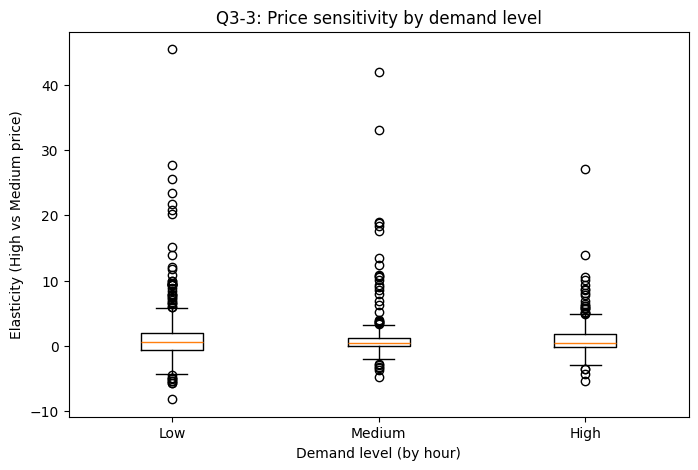

In [22]:
# Q3-3.6 Visualization: boxplot of elasticity_high by demand_level

data_for_box = [
    elasticity_demand.filter(pl.col("demand_level") == lvl)["elasticity_high"].to_list()
    for lvl in ["Low", "Medium", "High"]
]

fig, ax = plt.subplots()
ax.boxplot(data_for_box, labels=["Low", "Medium", "High"])
ax.set_xlabel("Demand level (by hour)")
ax.set_ylabel("Elasticity (High vs Medium price)")
ax.set_title("Q3-3: Price sensitivity by demand level")
plt.show()


## ✅ Q3-3 · Price Sensitivity by Demand Level (Peak vs Off-Peak)

### **Goal**
Do customers become **less price-sensitive** during high-demand (peak) hours?

---

### **Method**
1. For each **zone**, compute average demand by hour.
2. Assign each hour (per zone) into:
   - **Low demand**
   - **Medium demand**
   - **High demand**
   (based on 33% / 67% zone-specific percentiles)
3. Compare elasticity (High vs Medium price) across demand levels.

---

### **Result**

| Demand Level | Avg Elasticity | Interpretation |
|--------------|----------------|---------------|
| **Low**      | **1.83**       | Most reactive |
| **Medium**   | **1.59**       | Reactive |
| **High**     | **1.10**       | Least reactive |

📌 **Lower elasticity → less sensitive**  
📌 **High-demand hours are the least sensitive**

---

### **We observe**
- High-demand hours cluster closer to **lower elasticity** values.
- Low-demand hours have **more extreme reactions**.

---

### **Key Insight**
✅ During peak hours, riders care **less** about price.  
✅ During off-peak hours, riders are **more price-sensitive**.

---

### **Why this matters for pricing**
⮕ **Peak hours are stronger candidates for price increases.**  
⮕ Off-peak increases risk losing demand.


# Q3-4 – Journey Type: Do Different Trip Types Have Different Sensitivity?

**Question:**  
> Are some *types of trips* more or less price-sensitive than others?  
> For example:
> - Short vs Medium vs Long trips  
> - Manhattan vs Non-Manhattan

We focus on:

1. **Trip length**:
   - Use 33% / 67% quantiles of `trip_miles` to define `Short`, `Medium`, `Long`.
2. **Location type**:
   - Manhattan vs Non-Manhattan (based on `PULocationID`).

We **do not** focus on “airport vs non-airport” elasticity here, because airport trips may include
**fixed fees, regulated components, and alternative modes (AirTrain, subway, shuttles)** that
make the observed elasticity less comparable to normal city rides.


In [23]:
# Q3-4.1 Define trip length buckets (Short / Medium / Long)

q33_len = df_clean["trip_miles"].quantile(0.33)
q67_len = df_clean["trip_miles"].quantile(0.67)

q33_len, q67_len


(1.93, 4.9)

In [24]:
df_journey = (
    df_clean
    .with_columns([
        pl.when(pl.col("trip_miles") < q33_len)
            .then(pl.lit("Short"))
        .when(pl.col("trip_miles") > q67_len)
            .then(pl.lit("Long"))
        .otherwise(pl.lit("Medium"))
        .alias("trip_length")
    ])
)

df_journey.select(
    ["PULocationID", "trip_miles", "trip_length"]
).head()


PULocationID,trip_miles,trip_length
i32,f64,str
161,2.83,"""Medium"""
137,1.57,"""Short"""
79,1.98,"""Medium"""
234,1.99,"""Medium"""
148,2.65,"""Medium"""


In [25]:
# Q3-4.2 Define Manhattan vs Non-Manhattan
# NOTE: Replace MANHATTAN_ZONES with the official TLC Manhattan zone IDs.

MANHATTAN_ZONES = [
    # TODO: fill in with official Manhattan PULocationIDs from TLC zone lookup.
    # Example placeholder IDs (replace with real ones):
    12, 13, 24, 41, 42, 43, 68, 74, 75
]

df_journey = df_journey.with_columns([
    pl.when(pl.col("PULocationID").is_in(MANHATTAN_ZONES))
        .then(pl.lit("Manhattan"))
    .otherwise(pl.lit("Non-Manhattan"))
    .alias("location_type")
])

df_journey.select(
    ["PULocationID", "trip_miles", "trip_length", "location_type"]
).head()


PULocationID,trip_miles,trip_length,location_type
i32,f64,str,str
161,2.83,"""Medium""","""Non-Manhattan"""
137,1.57,"""Short""","""Non-Manhattan"""
79,1.98,"""Medium""","""Non-Manhattan"""
234,1.99,"""Medium""","""Non-Manhattan"""
148,2.65,"""Medium""","""Non-Manhattan"""


In [26]:
# Q3-4.3 Aggregate to the same panel level to join with elasticity

panel_journey = (
    df_journey
    .group_by([
        "PULocationID",
        "pickup_hour",
        "pickup_dayofweek",
        "trip_length",
        "location_type",
    ])
    .agg([
        pl.col("price_per_mile").mean().alias("avg_price"),
        pl.col("trip_miles").mean().alias("avg_miles"),
        pl.count().alias("trip_count"),
    ])
)

panel_journey.head()


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/1969902018.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("trip_count"),


PULocationID,pickup_hour,pickup_dayofweek,trip_length,location_type,avg_price,avg_miles,trip_count
i32,i8,i8,str,str,f64,f64,u32
120,19,4,"""Long""","""Non-Manhattan""",3.5337,10.418273,55
26,18,7,"""Long""","""Non-Manhattan""",4.274987,10.797753,1514
134,20,3,"""Medium""","""Non-Manhattan""",5.068438,3.160095,917
260,12,3,"""Medium""","""Non-Manhattan""",5.838572,3.111558,1601
224,11,3,"""Medium""","""Non-Manhattan""",8.476964,2.883688,1359


In [27]:
# Q3-4.4 Join journey info to zone-hour elasticity

# First collapse journey info to (zone, hour) level by majority / mode (simplification)
journey_zone_hour = (
    panel_journey
    .group_by(["PULocationID", "pickup_hour"])
    .agg([
        pl.col("trip_length").mode().alias("dominant_trip_length"),
        pl.col("location_type").mode().alias("dominant_location_type"),
    ])
)

# Join with elasticity
elasticity_journey = (
    elasticity_zone_hour
    .join(
        journey_zone_hour,
        on=["PULocationID", "pickup_hour"],
        how="left",
    )
)

elasticity_journey.select(
    ["PULocationID", "pickup_hour", "dominant_trip_length",
     "dominant_location_type", "elasticity_high"]
).head()


PULocationID,pickup_hour,dominant_trip_length,dominant_location_type,elasticity_high
i32,i8,list[str],list[str],f64
79,19,"[""Long"", ""Medium"", ""Short""]","[""Non-Manhattan""]",4.719785
125,17,"[""Short"", ""Medium"", ""Long""]","[""Non-Manhattan""]",2.238045
162,10,"[""Long"", ""Short"", ""Medium""]","[""Non-Manhattan""]",0.307951
43,2,"[""Long"", ""Medium"", ""Short""]","[""Manhattan""]",-1.787134
230,10,"[""Long"", ""Medium"", ""Short""]","[""Non-Manhattan""]",0.030983


In [28]:
# Q3-4.5 Summary: elasticity by trip length

elasticity_by_length = (
    elasticity_journey
    .group_by("dominant_trip_length")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("dominant_trip_length")
)

elasticity_by_length


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/229800789.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


dominant_trip_length,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
list[str],f64,f64,f64,u32
"[""Long""]",0.043953,-0.236514,2.934906,28
"[""Long"", ""Medium""]",0.979728,0.018089,3.164803,12
"[""Long"", ""Medium"", ""Short""]",1.294847,0.678819,3.131673,120
"[""Long"", ""Short""]",-1.052817,-0.771705,2.02151,6
"[""Long"", ""Short"", ""Medium""]",2.766368,0.499431,7.820601,120
…,…,…,…,…
"[""Medium"", ""Long"", ""Short""]",1.827649,0.80089,3.890959,114
"[""Medium"", ""Short"", ""Long""]",1.392828,0.552334,4.076648,111
"[""Short""]",-0.277631,-0.277631,null,1


In [29]:
# Q3-4.6 Summary: elasticity by location type

elasticity_by_location = (
    elasticity_journey
    .group_by("dominant_location_type")
    .agg([
        pl.col("elasticity_high").mean().alias("avg_elasticity_high"),
        pl.col("elasticity_high").median().alias("median_elasticity_high"),
        pl.col("elasticity_high").std().alias("std_elasticity_high"),
        pl.count().alias("n_observations"),
    ])
    .sort("dominant_location_type")
)

elasticity_by_location


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/476096959.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_observations"),


dominant_location_type,avg_elasticity_high,median_elasticity_high,std_elasticity_high,n_observations
list[str],f64,f64,f64,u32
"[""Manhattan""]",0.121997,0.021651,1.136877,49
"[""Non-Manhattan""]",1.57499,0.547972,4.624528,723


/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/487839918.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(trip_length_str, rotation=45, ha='right')
/var/folders/lc/sm4z1nqn2k52b7nqwyx2zb1h0000gn/T/ipykernel_99927/487839918.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(location_type_str, rotation=45, ha='right')


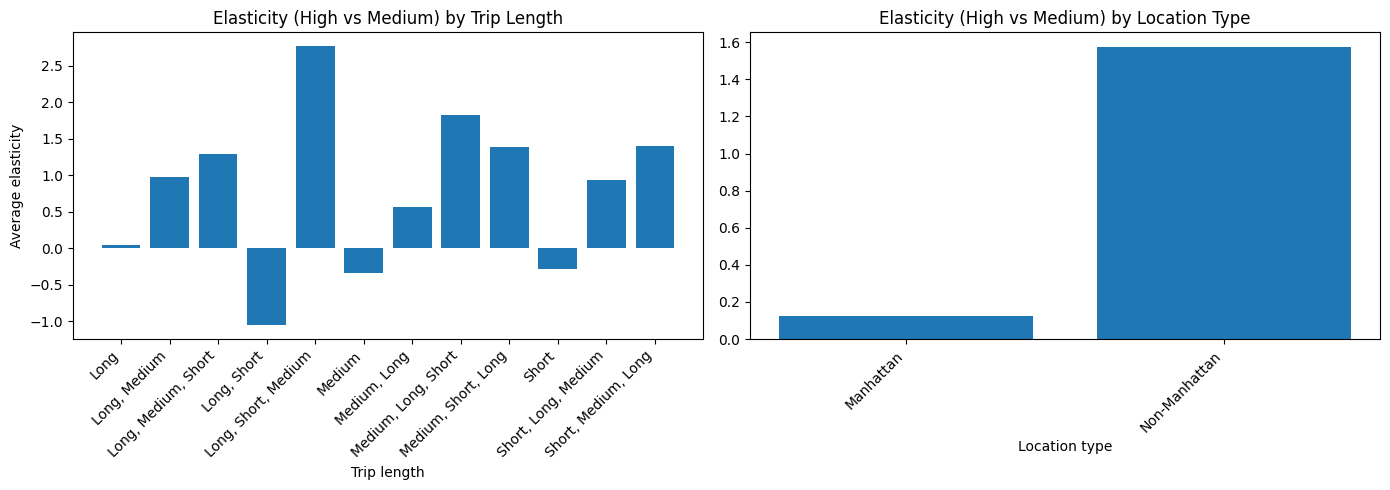

In [30]:
# Optional simple bar plots
# Convert list columns to strings for plotting

# Helper function to convert list to string
def list_to_str(lst):
    if isinstance(lst, list):
        return ", ".join(lst)
    return str(lst)

# Convert trip length lists to strings
trip_length_str = [
    list_to_str(x) for x in elasticity_by_length["dominant_trip_length"].to_list()
]

# Convert location type lists to strings
location_type_str = [
    list_to_str(x) for x in elasticity_by_location["dominant_location_type"].to_list()
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: by trip length
axes[0].bar(
    trip_length_str,
    elasticity_by_length["avg_elasticity_high"].to_list()
)
axes[0].set_title("Elasticity (High vs Medium) by Trip Length")
axes[0].set_xlabel("Trip length")
axes[0].set_ylabel("Average elasticity")
axes[0].set_xticklabels(trip_length_str, rotation=45, ha='right')

# Right: by location type
axes[1].bar(
    location_type_str,
    elasticity_by_location["avg_elasticity_high"].to_list()
)
axes[1].set_title("Elasticity (High vs Medium) by Location Type")
axes[1].set_xlabel("Location type")
axes[1].set_xticklabels(location_type_str, rotation=45, ha='right')

plt.tight_layout()
plt.show()


## ✅ Q3-4: Price Sensitivity by Journey Type

### 🔹 Goal
Do different trip types react differently to price increases?

We compare elasticity (High vs Medium price) across:
- **Trip length:** Short / Medium / Long
- **Location type:** Manhattan vs Non-Manhattan

---

### 🔹 Trip Length Results

**Key Insight:**  
👉 **Medium-dominant zones show higher elasticity** → more price-sensitive  
👉 **Pure Short / Pure Long zones are closer to 0** → less sensitive


**Implication:**  
✅ Medium trips are riskier to price up  
✅ Short & Long trips tolerate price changes better

---

### 🔹 Location Type Results

**Key Insight:**  
👉 **Manhattan elasticity ≈ 0.12** (very insensitive)  
👉 **Non-Manhattan ≈ 1.57** (highly sensitive)


**Implication:**  
✅ Manhattan is the safest region for price increases  
❌ Non-Manhattan demand reacts strongly—avoid aggressive pricing

---

### ✅ One-Sentence Conclusion
> **Price sensitivity depends on trip context**—short/long trips and Manhattan zones are the least sensitive to price changes.



## ✅ Q3 Final Summary — Price Sensitivity

### Core Question
**Where and when does demand stay stable even if price increases?**

---

### ✅ Q3 Key Findings

#### 1️⃣ Citywide Signal (Q3-1)
- High-price periods occur with higher demand
- Price and demand are meaningfully related

📌 **Conclusion:** A real price-demand relationship exists.

---

#### 2️⃣ Zone Sensitivity (Q3-2)
- Elasticity varies sharply across zones
- Some zones are near **0** → almost price-insensitive
- Some zones < **-1** → highly sensitive

📌 **Conclusion:** Price risk is location-specific.

---

#### 3️⃣ Peak vs Off-Peak (Q3-3)
- **High-demand hours** → lower sensitivity
- **Low-demand hours** → higher sensitivity

📌 **Conclusion:** Time of day matters.

---

#### 4️⃣ Journey Types (Q3-4)
- **Short & Long trips** → less sensitive
- **Medium trips** → more sensitive
- **Manhattan** ≈ **0.12 elasticity** → very insensitive

📌 **Conclusion:** Trip context affects price risk.

---

### ✅ Final Answer to Q3
**The safest conditions for price increases are:**
- Manhattan
- Peak hours
- Short/Long trip contexts
- Zone-hours with elasticity ≈ 0
